### Anomalies Detection on Health Insurance Claims

1. Exploratory Data Analysis
    + Features knowledge

### Claims Dataset Analysis

In [1]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.tools.plotting import scatter_matrix
mpl.style.use('ggplot')
%matplotlib inline

Esta es la segunda fase del análisis exploratorio de datos, primero se llevó a cabo un estudio de los eventos a nivel siniestro, se obtuvieron estadísticas importantes del comportamiento global de las pólizas siniestradas, en general como se comporta el promedio de reclamaciones a nivel geográfico y a nivel ramo, lo que conlleva a preguntarse ahora como se comporta a nivel reclamación y buscar lo más importante, segmentar el dataset para tener datasets de entrenamiento.

In [2]:
!pwd

/c/Users/A2276061/Documents/GMM


In [3]:
df = pd.read_csv("reclamaciones-desc.csv", parse_dates=True, encoding="latin1")

In [4]:
print(df.head())

   NSINIEST  NRECLAM        ID_RECLAM  STRECLAM DOCTOR DICTAMIN ID_HOSP  \
0  12050195        7  00012050195-007         4    NaN      ZM9     NaN   
1  13059473        8  00013059473-008         4    NaN      Z64     NaN   
2  14000856        7  00014000856-007         4    NaN      Z07     NaN   
3  13070219       10  00013070219-010         4    NaN      Z07     NaN   
4  14049359        5  00014049359-005         4    NaN      ZM9     NaN   

   FECHAREC  FINGHOSP  FEGRHOSP     ...       \
0   1150125         0         0     ...        
1   1150121         0         0     ...        
2   1150120         0         0     ...        
3   1150113         0         0     ...        
4   1150126         0         0     ...        

                                   DESC_PADECIMIENTO              TEL  \
0  VPH                                           ...                    
1                                                ...                    
2  CONDROMALACIA FEMOROPATELAR BILATERAL-

In [5]:
df.columns

Index(['NSINIEST', 'NRECLAM', 'ID_RECLAM', 'STRECLAM', 'DOCTOR', 'DICTAMIN',
       'ID_HOSP', 'FECHAREC', 'FINGHOSP', 'FEGRHOSP', 'EDO', 'SUBRAMO',
       'ID_CIUDAD', 'CIUDAD', 'NOM_HOSP', 'CONVENIO', 'SERVICIO', 'PAGADO',
       'ID_PADECIMIENTO', 'PADECIMIENTO', 'GENERO', 'EDO_CIVIL', 'EDAD',
       'FECHASIN', 'DESC_PADECIMIENTO', 'TEL', 'RAMSUBRAMO', 'NPOLIZA',
       'NASEG', 'ASEG_ID', 'ASEGURADO', 'NAGENTE', 'TRAMITE', 'ESPECIALIDAD'],
      dtype='object')

Hay varias variables que se necesita ajustar además de tener una cifra control del total de reclamaciones

+ El estatus de la reclamación es importante, 4 es pagada, y 5 es rechazada
+ Para la variable Doctor no necesariamente debe estar relacionada a una reclamación, 
+ El ID_HOSP es el rfc del hospotal, cuando no hay entonces no hay institución asociado
+ Las fechas tienen que pasar por un paso de transformación a date
+ Considerar que el padecimiento, desc del padecimiento y la especialidad deben estar relacionados
+ Convenio es la bandera que indica si el hospital es de red =1 o no tiene=2
+ Tramite es la via por la que se hizo el pago

In [6]:
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum()/len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table

In [7]:
missing = missing_values_table(df)
missing = missing[missing['Missing Values'] > 0] #showing only all those are not zero
print(missing)

              Missing Values  % of Total Values
DOCTOR                877088          69.729973
DICTAMIN               24044           1.911538
ID_HOSP               877845          69.790155
ID_CIUDAD              24246           1.927598
CIUDAD                 24246           1.927598
NOM_HOSP              910382          72.376902
CONVENIO              910382          72.376902
SERVICIO              977856          77.741198
PAGADO                259169          20.604372
PADECIMIENTO           54700           4.348742
GENERO                159481          12.679008
EDO_CIVIL             159481          12.679008
EDAD                  159481          12.679008
NASEG                     13           0.001034
ESPECIALIDAD          884672          70.332913


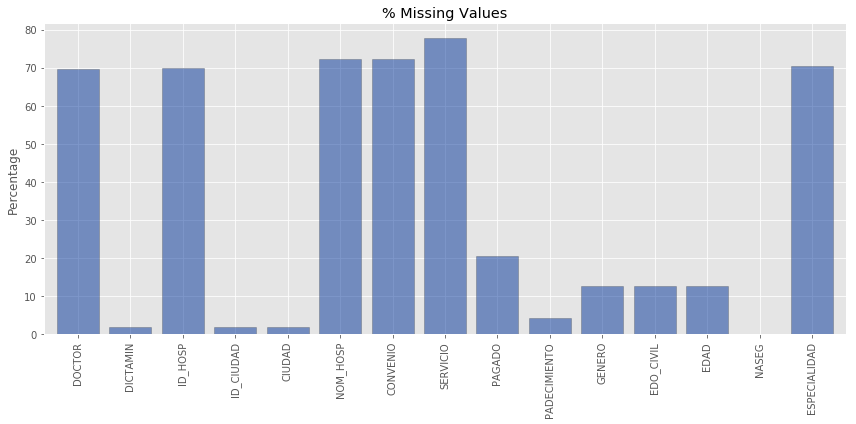

In [8]:
fig = plt.figure(figsize=[12, 6])

ax = missing['% of Total Values'].plot(kind='bar', width=0.8, alpha=0.5, color='#003399', edgecolor='#333333')
ax.yaxis.grid(True)
ax.set_title('% Missing Values')
ax.set_ylabel('Percentage')

fig.tight_layout() #for some reason this line should stay here
plt.show()

As we see the missing values are not gonna represent an important issue for data analysis, we have to decide as well
+ Imputation methods
+ Excusion methods

In [9]:
#Filling Na??
#df[df['DOCTOR'].isnull()]
df['DOCTOR'] = df['DOCTOR'].fillna('SV')
df['ID_HOSP'] = df['ID_HOSP'].fillna('SV')
df['NOM_HOSP'] = df['NOM_HOSP'].fillna('SV')
df['SERVICIO'] = df['SERVICIO'].fillna('SV')
df['ESPECIALIDAD'] = df['ESPECIALIDAD'].fillna('SV')

In [10]:
#columns and data types
df.dtypes

NSINIEST               int64
NRECLAM                int64
ID_RECLAM             object
STRECLAM               int64
DOCTOR                object
DICTAMIN              object
ID_HOSP               object
FECHAREC               int64
FINGHOSP               int64
FEGRHOSP               int64
EDO                   object
SUBRAMO               object
ID_CIUDAD            float64
CIUDAD                object
NOM_HOSP              object
CONVENIO             float64
SERVICIO              object
PAGADO               float64
ID_PADECIMIENTO       object
PADECIMIENTO          object
GENERO               float64
EDO_CIVIL            float64
EDAD                 float64
FECHASIN               int64
DESC_PADECIMIENTO     object
TEL                   object
RAMSUBRAMO             int64
NPOLIZA                int64
NASEG                 object
ASEG_ID               object
ASEGURADO             object
NAGENTE                int64
TRAMITE               object
ESPECIALIDAD          object
dtype: object

Revisando la variable estatus de reclamación

In [11]:
#Nos quedamos con las reclamaciones Pagadas y Rechazadas
df = df[(df['STRECLAM']==4) | (df['STRECLAM']==5)]

In [12]:
df['STRECLAM'] = np.where(df['STRECLAM']==4, 1, 0)

In [13]:
df.groupby('STRECLAM').size()

STRECLAM
0      20545
1    1073090
dtype: int64

In [14]:
20545/1073090*100
#se rechazan el 2% de las reclamaciones

1.9145644820098968

In [15]:
df['CONVENIO'] = df['CONVENIO'].fillna(3)

In [16]:
#Fill estado civil
df.groupby('EDO_CIVIL').size()

EDO_CIVIL
0.0    804605
1.0     83790
2.0     87565
3.0      2142
4.0      1407
dtype: int64

In [17]:
df['EDO_CIVIL'] = df['EDO_CIVIL'].fillna(0)

In [18]:
#Fill genero
df.groupby('GENERO').size()

GENERO
0.0     26775
1.0    432706
2.0    520028
dtype: int64

In [19]:
df['GENERO'] = df['GENERO'].fillna(0)

In [20]:
df['EDAD'] = df['EDAD'].fillna(df['EDAD'].mean())

In [21]:
df['PAGADO'] = df['PAGADO'].fillna(0)

In [22]:
#parseamos las fechas de reclamación y nos quedamos a partir del 2000
df = df[(df['FECHAREC']-1000000+20000000) >=20000000]

In [23]:
df['FECHAREC'] = pd.to_datetime((df['FECHAREC']-1000000+20000000).astype(str), format='%Y%m%d', errors='coerce')

In [24]:
df['FINGHOSP'] = pd.to_datetime((df['FINGHOSP']-1000000+20000000).astype(str), format='%Y%m%d', errors='coerce')

In [25]:
df['FEGRHOSP'] = pd.to_datetime((df['FEGRHOSP']-1000000+20000000).astype(str), format='%Y%m%d', errors='coerce')

In [26]:
df['FECHASIN'] = pd.to_datetime((df['FECHASIN']-1000000+20000000).astype(str), format='%Y%m%d', errors='coerce')

Construcción de variables de días

In [27]:
df['DIAS_SIN_REC']=df['FECHAREC']-df['FECHASIN']
df['DIAS_ING_EGR']=df['FEGRHOSP']-df['FINGHOSP']
df['DIAS_SIN_ING']=df['FINGHOSP']-df['FECHASIN']

In [28]:
df['DIAS_SIN_REC'] = df['DIAS_SIN_REC']/np.timedelta64(1, 'D')
df['DIAS_ING_EGR'] = df['DIAS_ING_EGR']/np.timedelta64(1, 'D')
df['DIAS_SIN_ING'] = df['DIAS_SIN_ING']/np.timedelta64(1, 'D')

In [29]:
#df['EDO'].unique()
df['EDO_GRUPO'] = df['EDO'].replace(['SAN LUIS POTOSI', 'TAMAULIPAS', 'EXTRANJERO',
       'ZACATECAS', 'QUERETARO', 'JALISCO', 'AGUASCALIENTES',
       'EDO. MEXICO', 'COLIMA', 'COAHUILA', 'PUEBLA', 'CHIHUAHUA',
       'GUANAJUATO', 'DURANGO', 'BAJA CALIFORNIA NORTE', 'YUCATAN',
       'SONORA', 'TABASCO', 'VERACRUZ', 'QUINTANA ROO', 'NO IDENTIFICADO',
       'MORELOS', 'SINALOA', 'NAYARIT', 'MICHOACAN', 'GUERRERO', 'HIDALGO',
       'CHIAPAS', 'CAMPECHE', 'OAXACA', 'TLAXCALA', 'BAJA CALIFORNIA SUR'],'OTRO EDO')

Se obtiene la palabra más relevante del campo descripción padecimiento

In [30]:
df['STR_PADECIMIENTO'] = df['DESC_PADECIMIENTO'].str.split().str.get(0)

In [31]:
#df[['PADECIMIENTO','ESPECIALIDAD','STR_PADECIMIENTO']]

In [32]:
df['CLAIMS']=1

Escribimos a tabla para analizar en Tableau

In [33]:
df

,NSINIEST,NRECLAM,ID_RECLAM,STRECLAM,DOCTOR,DICTAMIN,ID_HOSP,FECHAREC,FINGHOSP,FEGRHOSP,...,ASEGURADO,NAGENTE,TRAMITE,ESPECIALIDAD,DIAS_SIN_REC,DIAS_ING_EGR,DIAS_SIN_ING,EDO_GRUPO,STR_PADECIMIENTO,CLAIMS
0,12050195,7,00012050195-007,1,SV,ZM9,SV,2015-01-25,NaT,NaT,...,JUAREZ JIMENEZ JATZIRI BRISA,12216,REEMBOLSO,SV,891.0,NaN,NaN,CIUDAD DE MEXICO,VPH,1
1,13059473,8,00013059473-008,1,SV,Z64,SV,2015-01-21,NaT,NaT,...,ARRIAGA VALDES ROCIO,12216,REEMBOLSO,SV,510.0,NaN,NaN,OTRO EDO,NaN,1
2,14000856,7,00014000856-007,1,SV,Z07,SV,2015-01-20,NaT,NaT,...,MURO PICO JESUS FERNANDO,12216,REEMBOLSO,SV,476.0,NaN,NaN,OTRO EDO,CONDROMALACIA,1
3,13070219,10,00013070219-010,1,SV,Z07,SV,2015-01-13,NaT,NaT,...,OSCAR RAMIREZ MERCADO,1058,REEMBOLSO,SV,386.0,NaN,NaN,OTRO EDO,VIRUS,1
4,14049359,5,00014049359-005,1,SV,ZM9,SV,2015-01-26,NaT,NaT,...,GARCIA GARCIA ANDRES,12216,REEMBOLSO,SV,101.0,NaN,NaN,CIUDAD DE MEXICO,HALLUX,1
5,14048674,3,00014048674-003,1,GAGM8012151R3,Z81,CNA1209189Y8,2014-11-06,2014-10-14,NaT,...,PEREZ HERNANDEZ JUAN CARLOS,12216,PAGO DIRECTO HOSPITAL,OTRAS,23.0,NaN,0.0,NUEVO LEON,NaN,1
6,12002620,27,00012002620-027,1,SV,Z25,SV,2015-03-05,NaT,NaT,...,MUNIZ IRIGOYEN JUAN MANUEL,210,REEMBOLSO,SV,1155.0,NaN,NaN,CIUDAD DE MEXICO,NaN,1
7,11027370,16,00011027370-016,1,SV,Z07,SV,2015-02-17,NaT,NaT,...,AGUSTIN FLORES ESCOBAR,4378,REEMBOLSO,SV,1283.0,NaN,NaN,OTRO EDO,DIABETES,1
8,14059011,1,00014059011-001,1,SV,AUT,OHA051017KE7C,2015-01-12,2014-12-21,2014-12-22,...,GUTIERREZ GARCIA EDWIN RUBEN,230,PAGO DIRECTO HOSPITAL,SV,27.0,1.0,5.0,CIUDAD DE MEXICO,APENDICITIS,1
9,14059337,3,00014059337-003,1,LEPR740524741,Z81,SV,2014-12-19,NaT,NaT,...,CRISTINA CARRILLO GARCIA,8659,PAGO DIRECTO MEDICOS,OTRAS,1.0,NaN,NaN,NUEVO LEON,BRONQUITIS,1


In [34]:
df.to_csv('reclamaciones.csv', sep=',', encoding="latin1")

In [34]:
df.columns

Index(['NSINIEST', 'NRECLAM', 'ID_RECLAM', 'STRECLAM', 'DOCTOR', 'DICTAMIN',
       'ID_HOSP', 'FECHAREC', 'FINGHOSP', 'FEGRHOSP', 'EDO', 'SUBRAMO',
       'ID_CIUDAD', 'CIUDAD', 'NOM_HOSP', 'CONVENIO', 'SERVICIO', 'PAGADO',
       'ID_PADECIMIENTO', 'PADECIMIENTO', 'GENERO', 'EDO_CIVIL', 'EDAD',
       'FECHASIN', 'DESC_PADECIMIENTO', 'TEL', 'RAMSUBRAMO', 'NPOLIZA',
       'NASEG', 'ASEG_ID', 'ASEGURADO', 'NAGENTE', 'TRAMITE', 'ESPECIALIDAD',
       'DIAS_SIN_REC', 'DIAS_ING_EGR', 'DIAS_SIN_ING', 'EDO_GRUPO',
       'STR_PADECIMIENTO', 'CLAIMS'],
      dtype='object')

In [53]:
df_2016 = df[(df['FECHAREC']>='01-01-2016') & 
             (df['FECHAREC']<'01-01-2017') &
             (df['STRECLAM']==1) & 
             (df['NSINIEST']>11000000) & 
             (df['PAGADO']>0)]

In [54]:
df_2016['PAGADO'].sum()

55220062040.692635

In [56]:
df_2016[['NSINIEST','NRECLAM','PAGADO']].sort_values(by=['NSINIEST','NRECLAM'], ascending=[1,0]).count()

NSINIEST    67663
NRECLAM     67663
PAGADO      67663
dtype: int64

In [65]:
df_2016[df_2016['NSINIEST'] == 11027370][['NSINIEST','NRECLAM','FECHASIN','FECHAREC','PAGADO','NOM_HOSP']]

,NSINIEST,NRECLAM,FECHASIN,FECHAREC,PAGADO,NOM_HOSP
2543,11027370,20,2011-08-14,2016-02-18,180696.0,"HOSPITAL SAN JAVIER MARINA, S.A. DE C.V."


In [84]:
df.shape

(1093351, 35)

In [85]:
pd.set_option('display.width', 100)
pd.set_option('precision', 3)
df.describe()

,NSINIEST,NRECLAM,STRECLAM,ID_CIUDAD,CONVENIO,PAGADO,GENERO,EDO_CIVIL,EDAD,NAGENTE,DIAS_SIN_REC,DIAS_ING_EGR,DIAS_SIN_ING
count,1.093e+06,1.093e+06,1.093e+06,1.069e+06,329048.000,9.984e+05,979255.000,979255.000,979255.000,1.093e+06,1092962,313351,336144
mean,2.243e+07,4.906e+00,9.812e-01,4.334e+00,1.027,8.111e+03,1.504,0.277,35.138,6.875e+03,251 days 10:43:38.190202,1 days 03:42:21.705627,124 days 23:24:57.472511
std,1.743e+08,1.042e+01,1.358e-01,3.877e+00,0.163,2.356e+04,0.552,0.640,20.827,4.240e+03,1740 days 21:00:53.185762,161 days 09:22:09.082476,1312 days 13:15:42.590515
min,1.700e+01,0.000e+00,0.000e+00,1.000e+00,1.000,0.000e+00,0.000,0.000,0.000,0.000e+00,-6524 days +00:00:00,-73047 days +00:00:00,-3652 days +00:00:00
25%,9.015e+06,0.000e+00,1.000e+00,1.000e+00,1.000,1.043e+03,1.000,0.000,19.000,4.493e+03,22 days 00:00:00,0 days 00:00:00,0 days 00:00:00
50%,1.205e+07,2.000e+00,1.000e+00,3.000e+00,1.000,2.366e+03,2.000,0.000,35.000,5.602e+03,54 days 00:00:00,0 days 00:00:00,0 days 00:00:00
75%,1.404e+07,5.000e+00,1.000e+00,7.000e+00,1.000,7.200e+03,2.000,0.000,50.000,1.222e+04,168 days 00:00:00,1 days 00:00:00,35 days 00:00:00
max,3.051e+09,2.760e+02,1.000e+00,2.300e+01,2.000,3.579e+06,2.000,4.000,114.000,1.847e+05,41806 days 00:00:00,32872 days 00:00:00,73048 days 00:00:00


In [96]:
df._get_numeric_data().columns

Index(['NSINIEST', 'NRECLAM', 'STRECLAM', 'ID_CIUDAD', 'CONVENIO', 'PAGADO', 'GENERO', 'EDO_CIVIL',
       'EDAD', 'NAGENTE'],
      dtype='object')

In [97]:
#correlations
#df_transformed = df._get_numeric_data()
numeric_features = df[['STRECLAM', 'ID_CIUDAD', 'CONVENIO', 'PAGADO', 'GENERO', 'EDO_CIVIL','EDAD']]
correlations = numeric_features.corr(method='pearson')
print(correlations)

           STRECLAM  ID_CIUDAD  CONVENIO  PAGADO  GENERO  EDO_CIVIL   EDAD
STRECLAM      1.000      0.002     0.004     NaN  -0.002     -0.016 -0.009
ID_CIUDAD     0.002      1.000     0.021  -0.042  -0.049      0.140 -0.187
CONVENIO      0.004      0.021     1.000  -0.020   0.010     -0.016 -0.028
PAGADO          NaN     -0.042    -0.020   1.000  -0.035      0.006  0.067
GENERO       -0.002     -0.049     0.010  -0.035   1.000      0.067  0.203
EDO_CIVIL    -0.016      0.140    -0.016   0.006   0.067      1.000  0.052
EDAD         -0.009     -0.187    -0.028   0.067   0.203      0.052  1.000


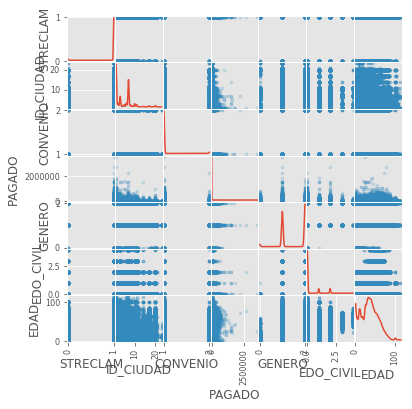

In [99]:
plt.figure(figsize=[10,10])
scatter_matrix(numeric_features, alpha=0.2, figsize=(6, 6), diagonal='kde')
plt.show()

In [100]:
skew = numeric_features.skew()
print(skew)

STRECLAM     -7.090
ID_CIUDAD     1.427
CONVENIO      5.805
PAGADO       20.367
GENERO       -0.502
EDO_CIVIL     2.257
EDAD          0.206
dtype: float64


---
Is clear we need to scalate and normalize

##### Time Serires

For this dataset we are analysing the sinisters global, the natural approach is visualize the time series envolved  

The fisrt thing we have to do is convert date fields on data type, because as we see on dtypes is not clear

In [42]:
#Beging of 
df['SINISTER_DATE']=pd.to_datetime(df['SINISTER_DATE'])
df['DATE_INIT']=pd.to_datetime(df['DATE_INIT'])
df.head()

,NSINIEST,NPOLIZA,RAMSUBRAMO,RAMO,SUBRAMO,DATE_INIT,INI_ANIO,INDIVIDUAL,EDO,STATE_NAME,...,AGE,SINISTER_DATE,TIPOSIN,SIN_DECRIPTION,DIS_DESCRIPTION,COVERS,TOTAL_CLAIM,TOTAL_PAID,DIFF_MOUNT,CLAIMS
0,16039182,1011,1035,GMM,GMM COLECTIVO,2015-01-08,1,1,19,N.L.,...,NaN,2016-08-16,300,ACCIDENTE,RUPTURA DE MENISCO MEDIAL + LISTESIS OSEA RODI...,NaN,NaN,NaN,NaN,2
1,17003837,610201,1035,GMM,GMM COLECTIVO,2016-09-30,2,2,14,JAL,...,NaN,2012-01-01,100,ENFERMEDAD,FISTULA ANAL CRIPTOGLANDULAR ...,NaN,NaN,NaN,NaN,2
2,16051270,101101,1030,GMM,GMM COLECTIVO,2016-01-05,2,2,11,GTO,...,NaN,2016-11-25,100,ENFERMEDAD,PARAFIMOSIS Y BALANITIS ...,NaN,NaN,NaN,NaN,6
3,16039194,22201,1026,GMM,GMM COLECTIVO,2015-09-28,1,2,8,CHIH,...,NaN,2016-08-18,100,ENFERMEDAD,SD PINZAMIENTO + TENDINOSIS PORCION LARGA DE B...,NaN,NaN,NaN,NaN,3
4,16046314,80102,1032,GMM,GMM COLECTIVO,2016-01-04,1,2,15,EDMEX,...,NaN,2016-10-25,300,ACCIDENTE,DESGARRO DEL MENISCO MEDIAL ...,NaN,NaN,NaN,NaN,2


In [43]:
df[['SINISTER_DATE','DATE_INIT']].dtypes

SINISTER_DATE    datetime64[ns]
DATE_INIT        datetime64[ns]
dtype: object

In [44]:
#take the fisrt column . groupby () and measure of aggregation
# like agg(['mean', 'count'])
dfy = df['NSINIEST'].groupby(df['SINISTER_DATE'].map(lambda x: x.year)).agg(['count'])
print(dfy.head())

               count
SINISTER_DATE       
2000             546
2001            4784
2002            5021
2003            5148
2004            7511


In [45]:
#test[['NSINIEST','AGE']].groupby(test['SINISTER_DATE'].map(lambda x: x.year)).agg(['count','mean'])
#this is just another approach of agregation

In [46]:
dfy.columns
dfy.dtypes

count    int64
dtype: object

In [47]:
#The rule we gonna use is excluding all the data with days more than 2 estandart deviatin_
two_dev = 2*dfy.std().astype(int)
two_dev

count    16968
dtype: int32

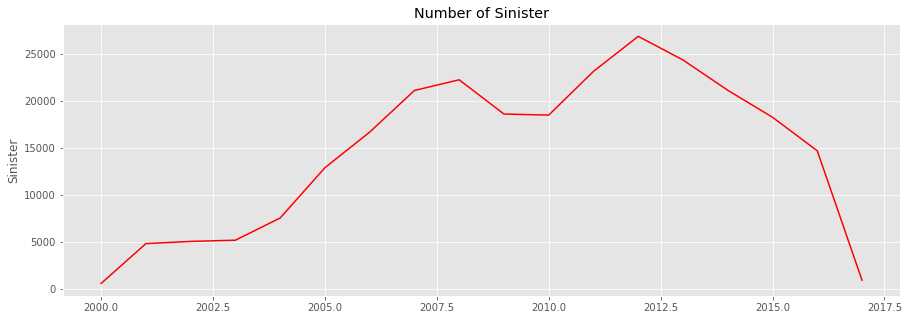

In [48]:
plt.figure(figsize=[15, 5])
plt.plot(dfy, color='red') 
plt.title("Number of Sinister")
plt.ylabel('Sinister')
plt.show()

+ Can we find something seasonal?
+ Sinister by month it matters? Let's make a plot by month

In [49]:
dfm = df['NSINIEST'].groupby(df['SINISTER_DATE'].map(lambda x: x.month)).agg(['count'])
print(dfm.head())

               count
SINISTER_DATE       
1              30094
2              21938
3              22344
4              21623
5              24100


In [50]:
two_dev = 2*dfy.std().astype(int)
two_dev

count    16968
dtype: int32

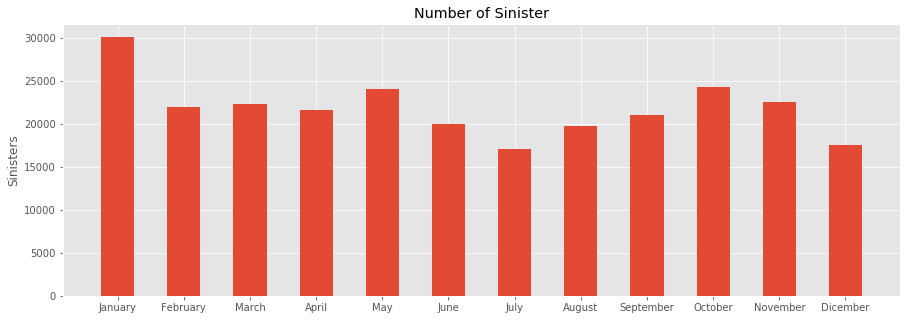

In [51]:
plt.figure(figsize=[15,5])
axx=np.arange(dfm.count())
plt.xticks(axx, ('January', 'February', 'March', 'April', 'May', 
            'June', 'July', 'August', 'September', 'October', 'November', 'Dicember'))
plt.ylabel('Sinisters')
plt.title('Number of Sinister')
plt.bar(axx, dfm['count'], width=.5)
plt.show()

The best approach is convert this to series, and take out the outliers

In [52]:
#df_dates = df.groupby(df['SINISTER_DATE'].apply(lambda x : x.date()))
#df_dates['SINISTER_DATE'].aggregate(len)

df_dates = df['NSINIEST'].groupby(df['SINISTER_DATE'].map(lambda x: x.date())).agg(['count'])
print(df_dates.head())

               count
SINISTER_DATE       
2000-01-01        12
2000-01-02         3
2000-01-03         3
2000-01-04         7
2000-01-05         4


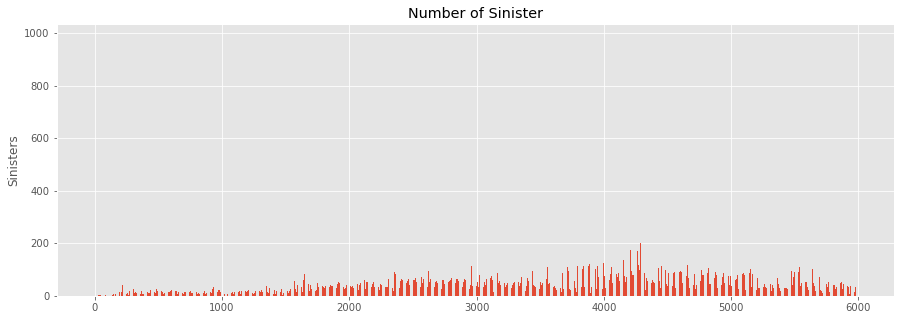

In [205]:
plt.figure(figsize=[15,5])
plt.ylabel('Sinisters')
plt.title('Number of Sinister')
plt.bar(np.arange(df_dates.count()), df_dates['count'], width=.5)
plt.show()

In [54]:
df_dates.describe()

,count
count,5979.000
mean,43.825
std,36.490
min,1.000
25%,20.000
50%,38.000
75%,60.000
max,986.000


First of all, the mean changes a lot